 ##                                             CAPSTONE PROJECT
 
 ### Predicting the Next Pitch
 
             
 



**KRISHNA BHATIA**

**26thOctober, 2017**

### Project Overview

Baseball has become a very analytical sport and now it seems as if everything can be analyzed with data. In this new world, teams have started to implement numerous analytical techniques including defensive shifts, individual statistical importance, batter tendencies based on pitch locations, etc. This data based strategy had become popular from Billy Bean and his Sabermetrics. Here, I will try to apply another statistical approach on the basis on machine-learning by trying to predict the next pitch a pitcher will throw by incorporating information that is available to a batter such as the count, the current game state, pitcher’s tendency to throw a particular type of pitch, etc. This becomes a multi-classification problem by predicting the next pitch type.

##### Importing necessary libraries

In [3]:
# import libraries
import numpy as np
import pandas as pd
import io
from __future__ import division
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
% matplotlib inline
# website parsing 
from bs4 import BeautifulSoup
import urllib2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#all players lookup table 
# only added a select few 
players = {'Dallas Keuchel': 572971,
          'Jake Arrieta': 453562,
          'Madison Bumgarner': 518516,
          'Clayton Kershaw': 477132,
          'Sonny Gray': 543243,
          'Justin Verlander': 434378,
          'Jacob deGrom': 594798}

In [5]:
def player_data(name):
    '''Receives Player Full Name, downloads pitch individual game data from www.brooksbaseball.net
        and saves it to created csv, if is data already uploaded it reads from file'''
    player_id = players[name]
    dat = pd.read_csv('player/' + name + '.csv')
    return dat

#### Reading the data

In [6]:
dat = player_data('Dallas Keuchel')
dat.head()

,dateStamp,park_sv_id,play_guid,ab_total,ab_count,pitcher_id,batter_id,ab_id,des,type,...,ax,ay,az,start_speed,px,pz,pxold,pzold,sb,pitch_count
0,2012-06-17,120617_141612tex,NaN,6,1,572971,435079,4,Groundout,S,...,15.515,24.060000,-20.442000,86.75,0.536001,1.733924,0.529,1.829,0,1
1,2012-06-17,120617_141627tex,NaN,6,2,572971,435079,4,Groundout,B,...,15.226,30.318000,-14.345000,88.97,2.330349,3.465856,2.326,3.562,1,2
2,2012-06-17,120617_141640tex,NaN,6,3,572971,435079,4,Groundout,S,...,8.501,19.569001,-24.674000,72.91,0.977386,1.117343,0.970,1.230,11,3
3,2012-06-17,120617_141700tex,NaN,6,4,572971,435079,4,Groundout,B,...,11.979,20.967000,-24.707001,74.49,1.302390,1.176717,1.295,1.286,12,4
4,2012-06-17,120617_141718tex,NaN,6,5,572971,435079,4,Groundout,B,...,15.897,29.724000,-20.285000,88.59,1.045238,3.266055,1.040,3.361,22,5


#### Creating and Tranforming Features



Initial Walk Pitches and Pitch Outs are Deleted

In [11]:
# delete intential walk pitches
dat = dat[dat['mlbam_pitch_name'] != 'IN']
# delete pitch out pitches
dat = dat[dat['mlbam_pitch_name'] != 'PO']

ADD if play results in an **OUT**

In [12]:
def add_out(row):
    outs = 0
    if row[-6:] == 'out(s)':
        outs = 1
    return outs
        
dat['out'] = dat['pdes'].apply(add_out)

ADD current number of **OUTS** to the current situtation

In [13]:
# set limit so number of outs stops at 3
limit = 3
dat['outs'] = np.cumsum(dat['out']) % limit
dat['outs'] = dat['outs'].shift(1)
dat['outs'] = dat['outs'].fillna(0)

Alter and bin numerical pitch location numbers to corresponding pitch location category

In [14]:
def pitch_location(row):
    zone, batter = row 
    if batter == 'R':
        if zone in [0,1,5,6,10,11,15,16,20,21]:
            return 'inside'
        elif zone in [2,7,12,17,22]:
            return 'center'
        else:
            return 'outside'
    if batter == 'L':
        if zone in [0,1,5,6,10,11,15,16,20,21]:
            return 'outside'
        elif zone in [2,7,12,17,22]:
            return 'center'
        else:
            return 'inside'
        
dat['pitch_location'] = dat[['zone_location', 'stand']].apply(pitch_location, axis = 1)

Alter and bin numerical pitch location numbers to corresponding pitch location category

In [15]:
dat['prev_pitch_outcome'] = dat['pdes'].shift(1)
dat['prev_pitch_speed'] = dat['start_speed'].shift(1)
dat['prev_pitch_location'] = dat['pitch_location'].shift(1)
dat['prev_pdes'] = dat['pdes'].shift(1)
dat['prev_des'] = dat['des'].shift(1)
dat['prev_out'] = dat['out'].shift(1)

Change the dependant, y to make all different types of fastballs into one, and add previous pitch to next pitch

In [16]:
def convert_pitches(row):
    if row in ['FA', 'FC', 'FF', 'FT', 'FS', 'UN', 'SI']:
        return 'FB'
    else:
        return row
    
dat['current_pitch'] = dat['mlbam_pitch_name'].apply(convert_pitches)
dat['prev_pitch_type'] = dat['current_pitch'].shift(1)

Pitch percentage by pitch. Sorted in alphabetical order for reproducability and so it matches with sklearn's Label Encoder. Also set pitch column list to add desired columns to  X dataframe for reproducability for each different pitcher

In [17]:
pitch_percentage = []

for pitch in dat.current_pitch.order().unique():
    percent = len(dat.current_pitch[dat.current_pitch == pitch]) / dat.shape[0]
    pitch_percentage.append(percent)
    dat[pitch] = percent
    
pitch_columns = []
for column in dat.current_pitch.order().unique():
    pitch_columns.append(column)
    
zip(dat.current_pitch.order().unique(), pitch_percentage)

[('CH', 0.14314247669773636),
 ('CU', 0.03633250903557162),
 ('FB', 0.6472322617462432),
 ('SL', 0.17329275252044893)]

Bin prev_pitch_speed for prediction

In [18]:
if np.max(dat.prev_pitch_speed) > 90:
    max_speed = np.max(dat.prev_pitch_speed)
else:
    max_speed = 95

bins = [70, 75, 80, 85, 90, max_speed]
dat['prev_pitch_speed_bins'] = pd.cut(dat.prev_pitch_speed, bins = bins, include_lowest = True)

Pick out the ballpark city where the game is being played. Some parks are smaller and so are bigger as this could influence the type of pitch

In [19]:
dat['park'] = dat.park_sv_id.map(lambda x: x[-3:])


Pick out the day, month, year

Display the **DATA**

In [20]:
dat['day'] = dat.dateStamp.map(lambda x: x[-2:])
dat['month'] = dat.dateStamp.map(lambda x: x[5:7])
dat['year'] = dat.dateStamp.map(lambda x: x[:4])

In [21]:
dat.head()

,dateStamp,park_sv_id,play_guid,ab_total,ab_count,pitcher_id,batter_id,ab_id,des,type,...,prev_pitch_type,CH,CU,FB,SL,prev_pitch_speed_bins,park,day,month,year
0,2012-06-17,120617_141612tex,NaN,6,1,572971,435079,4,Groundout,S,...,NaN,0.143142,0.036333,0.647232,0.173293,NaN,tex,17,06,2012
1,2012-06-17,120617_141627tex,NaN,6,2,572971,435079,4,Groundout,B,...,CH,0.143142,0.036333,0.647232,0.173293,"(85, 90]",tex,17,06,2012
2,2012-06-17,120617_141640tex,NaN,6,3,572971,435079,4,Groundout,S,...,FB,0.143142,0.036333,0.647232,0.173293,"(85, 90]",tex,17,06,2012
3,2012-06-17,120617_141700tex,NaN,6,4,572971,435079,4,Groundout,B,...,CH,0.143142,0.036333,0.647232,0.173293,"[70, 75]",tex,17,06,2012
4,2012-06-17,120617_141718tex,NaN,6,5,572971,435079,4,Groundout,B,...,CH,0.143142,0.036333,0.647232,0.173293,"[70, 75]",tex,17,06,2012


## ANALYSIS

#### EXPLORATORY ANALYSIS

In [22]:
print 'The current pitchers dataset has {} rows and {} columns'.format(*dat.shape)

The current pitchers dataset has 10514 rows and 71 columns


In [23]:
# number of featues, subtract 2, one for the original predictor 
# and one for my newly created predictor that will replace the original
print 'There are {} number of features present'.format(len(dat.columns) - 2)

There are 69 number of features present


### GRAPHICAL REPRESENTATION

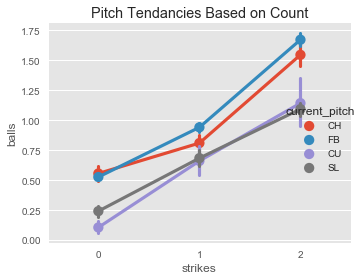

In [24]:
sns.factorplot(x = 'strikes', y = 'balls', data = dat, hue = 'current_pitch')
plt.title('Pitch Tendancies Based on Count')
plt.tight_layout()

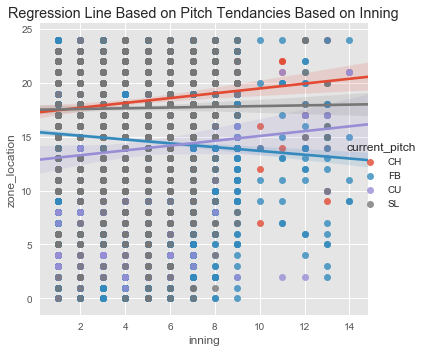

In [25]:
sns.lmplot(x = 'inning', y = 'zone_location', data = dat, hue = 'current_pitch')
plt.title('Regression Line Based on Pitch Tendancies Based on Inning')
plt.tight_layout()


#### Previous Pitch Outcome by INNING

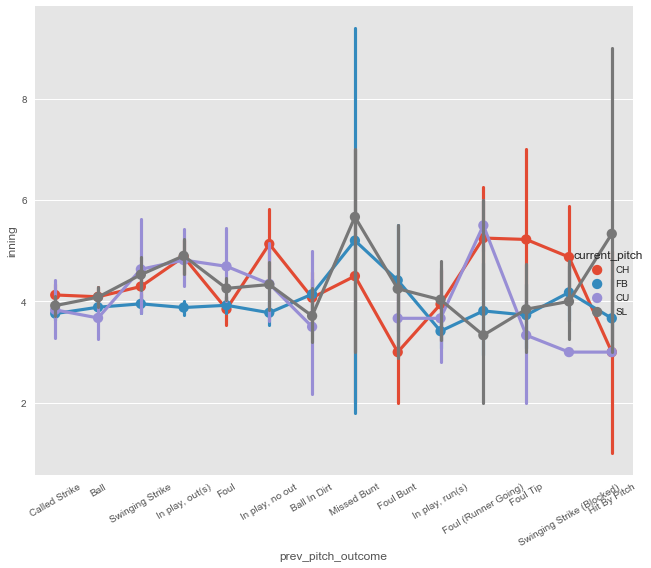

In [26]:
g = sns.factorplot('prev_pitch_outcome', 'inning', hue = 'current_pitch', data = dat, size = 8)
g.set_xticklabels(rotation=30)
plt.tight_layout()

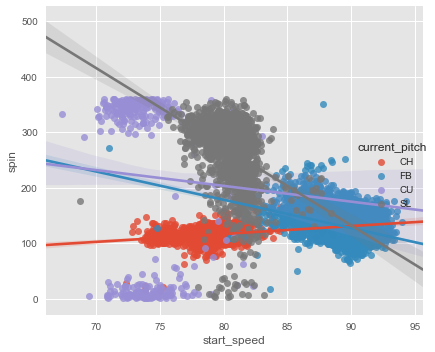

In [27]:
sns.lmplot('start_speed', 'spin', hue = 'current_pitch', data = dat)
plt.tight_layout()

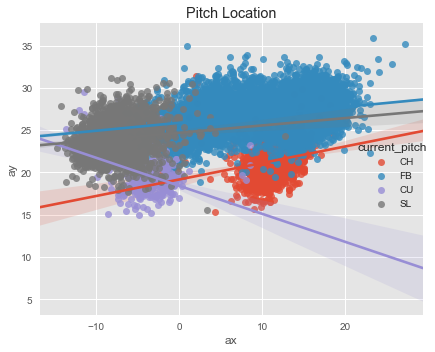

In [28]:
sns.lmplot(x = 'ax', y = 'ay', data = dat, hue = 'current_pitch')
plt.title('Pitch Location')
plt.tight_layout()

### Basic Statistics

Function to convert categorical variables to dummy variables and insert them into a new data frame. I will later combine this newly created dummy_dat dataframe with the original numerical features from dat for predictions

In [34]:
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)

    for col, col_data in X.iteritems():
        teams = pd.get_dummies(col_data, prefix = col)
        outX = outX.join(teams)
    return outX

dummy_dat = preprocess_features(dat[['stand', 'prev_pitch_type', 'prev_pitch_outcome', 'prev_pitch_location', 
                                     'prev_pdes', 'prev_des', 'prev_pitch_speed_bins', 'inning', 'ab_count', 
                                     'park', 'month', 'year']])

## Machine Learning Algorithms

### Implementation

#### Feature Vector

The Feature Vector consists of Batter Stance, Previous Pitch Type, Previous Pitch Outcome, Previous Pitch Location, Previous Description, Previous Pitch Speed, if there was a Previous Out, Current Inning, At Bat Pitch Count, Ballpark, Current Month, Current Year, and the Number of strikes, balls, and outs

In [35]:
X_df = dat[['strikes', 'balls', 'outs', 'prev_out', 'pxold', 'pzold'] + pitch_columns]
X_df = X_df.join(dummy_dat)
X_df[np.isnan(X_df)] = 0
X = dat[['strikes', 'balls', 'outs', 'prev_out','pxold', 'pzold'] + pitch_columns]
X = X.join(dummy_dat)
X = X.values
X[np.isnan(X)] = 0
y = dat['current_pitch'].values

X.shape

(10514L, 137L)

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(y)
le.classes_

array(['CH', 'CU', 'FB', 'SL'], dtype=object)

## Implementing Solution

### PCA

I incorporate Principal Component Analysis to get a better feel of the data. First I reduce the data into two dimensions so I can visualize them easily and produce a plot. Next I perform cluster analysis with Gaussian Mixture Model Clustering to split the data into the number of unique pitches the pitcher throws. Then, create a mesh grid for the reduced data, predict on the clustering and get the cluster centers and plot the data in two dimensions. This is more of an EDA approach rather than a unsupervised tactic.

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# reduce data to two dimensions
reduced_data = PCA(n_components = 2).fit_transform(X)

# initialize and fit cluster algorithm
# clusters = KMeans(n_clusters = len(le.classes_), random_state = 100).fit(reduced_data)
clusters = GMM(n_components = len(le.classes_), random_state = 100).fit(reduced_data)

C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function

In [38]:
# mesh grid for plotting
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max - x_min) / 1000.
hy = (y_max - y_min) / 1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh grid
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

# centroids = clusters.cluster_centers_
centroids = clusters.means_

C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


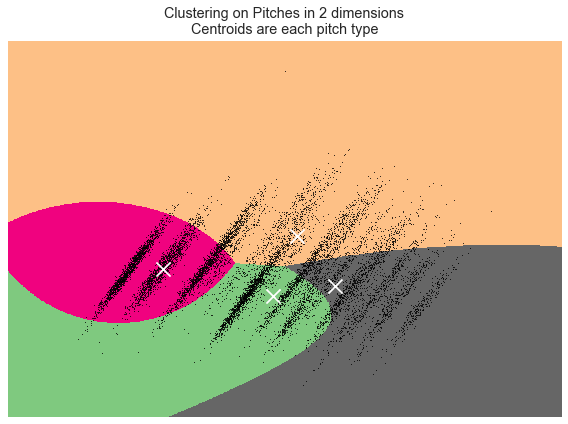

In [39]:
plt.figure(figsize=(8,6))

Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Accent_r, aspect = 'auto', origin = 'lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 200, 
            linewidths = 3, color = 'w', zorder = 10)

plt.title('Clustering on Pitches in 2 dimensions\n'
          'Centroids are each pitch type')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.tight_layout()

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X_new = SelectKBest(f_classif, k = 50).fit_transform(X_df, y)
X_new.shape


(10514L, 50L)

### Training Testing and Splitting the Data

In [41]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 100)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(7885L, 50L) (2629L, 50L) (7885L,) (2629L,)


C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Creating Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(clf):
    
    plt.figure(figsize=(8,4))
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, pred_train), annot = True, fmt = '')
    plt.title('%s \nTraining Confusion Matrix \nScore: %.4f' %(clf.__class__.__name__, clf.score(X_train, y_train)))
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')

    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, pred_test), annot = True, fmt = '')
    plt.title('%s \nTesting Confusion Matrix, \nScore: %.4f' %(clf.__class__.__name__, clf.score(X_test, y_test)))
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()

C:\Users\DELL\Anaconda2\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


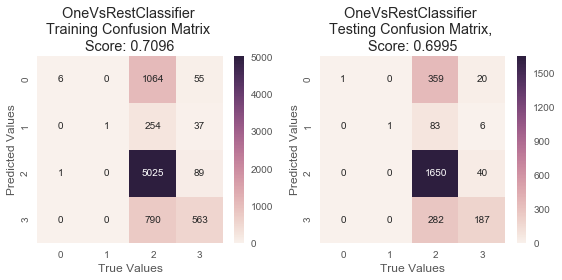

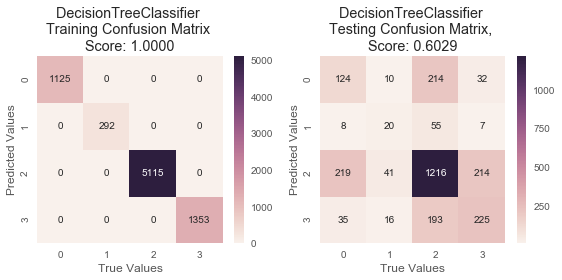

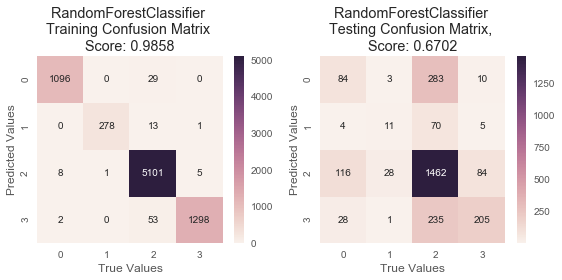

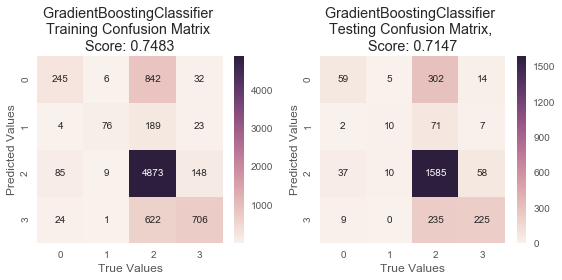

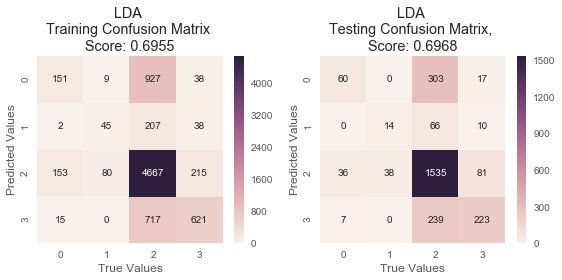

In [43]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.lda import LDA

classifiers = [
    OneVsRestClassifier(SVC()),
#     MultinomialNB(class_prior = pitch_percentage),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 100),
    GradientBoostingClassifier(),
    LDA(n_components=len(le.classes_))
]

for model in classifiers:
    clf = model
    clf.fit(X_train, y_train)
    create_confusion_matrix(clf)

### Refining the Solution


Two Models have been explore

- SVM
- Ensemble Method

In [ ]:
# not run as it takes an extremely long time
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(y)

param_grid = {
    'n_estimators': [50,100,200,300],
    'max_depth': [1,2,3,4,5],
}

clf = GradientBoostingClassifier()

grid = GridSearchCV(clf, param_grid, cv = cv)
grid.fit(X, y)

In [ ]:
# not run as it takes an extremely long time
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(y)

param_grid = {
    'C': [1, 10, 100, 200, 300, 400],
    'gamma': [0.0, 0.1, 0.01, 0.001, 0.0001],
}

clf = OneVsRestClassifier(SVC())

grid = GridSearchCV(clf, param_grid, cv = cv)
grid.fit(X, y)

### Final Solution

Between the two, Gradient Boosting proved to be the better Model.



In [44]:
from sklearn.ensemble import GradientBoostingClassifier
for i in range(45, 55):
    X_new = SelectKBest(f_classif, k = i).fit_transform(X_df, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 100)
    clf = GradientBoostingClassifier(n_estimators = 300, max_depth = 2)
    clf.fit(X_train, y_train)
    print clf.score(X_test, y_test)

0.715481171548
0.715100798783
0.715861544313
0.71776340814
0.718904526436
0.716241917079
0.716241917079
0.717383035375
0.717383035375
0.718524153671


#### Fitiing the Model


**Gradient Boosting Classifier**

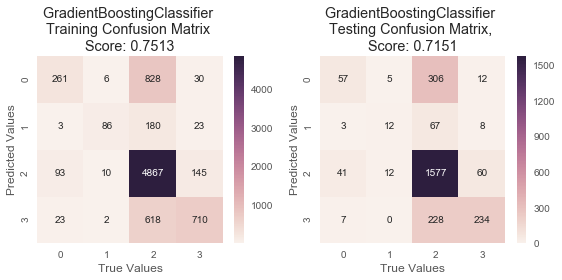

In [45]:
# chosen K from above
X_new = SelectKBest(f_classif, k = 46).fit_transform(X_df, y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 100)
# run with grid search best params
clf = GradientBoostingClassifier(n_estimators = 300, max_depth = 2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
create_confusion_matrix(clf)


**Support Vector Machine**

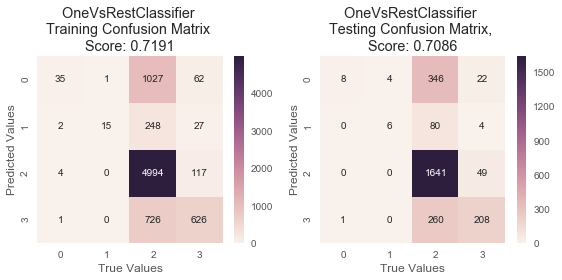

In [46]:
# run with grid search best params
clf = OneVsRestClassifier(SVC(gamma = 0.01, C = 20))
clf.fit(X_train, y_train)
create_confusion_matrix(clf)

### Result

After running these final models and continuing to tweak and create features, I finally realize that if I wanted to increase the performance anymore, I would need to obtain more relevant information on the teams and more on the current game situation. I would need more on the 'Batter Profile', including his Slugging Percentage and runs for each pitch class. Other features like defensing formation or something like weather could also be helpful in determining the environment the pitcher is throwing in.